# SWA Differences - SWI + SWISIN Experiments

In [17]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg

/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# IMPORTANT PARAMETERS
# --------------------
REBOUND_LENGTH = '1h'
REL_STATE = 'NREM'

# Slow-Wave Induction during Sleep Deprivation

In [3]:
fsd_df = pl.read_csv('sd_df.csv')
fsd_by_chan = fsd_df.filter(pl.col('Band')=='delta').groupby(['subject', 'channel', 'exp', 'store']).mean()
cut = fsd_by_chan.sort('Bandpower').filter(pl.col('Bandpower')<1.5)
good_chans = cut.groupby(['subject', 'exp', 'channel', 'store']).mean()
good_chans.filter((pl.col('subject')=='ACR_19') & (pl.col('exp')=='swi'))['channel'].unique().to_list()

[9, 10, 11, 12, 13, 14, 15, 16]

In [4]:
# Gets us the channels that are relatively artifact-free for each subject and experiment
chans = {}
for sub in swi_subs_exps:
    chans[sub] = {}
    for exp in swi_subs_exps[sub]:
        chans[sub][exp] = good_chans.filter((pl.col('subject')==sub) & (pl.col('exp')==exp))['channel'].unique().to_list()


In [5]:
chans['ACR_20']['swisin'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_20']['swi'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_23']['swisin'] = [9, 10, 11, 12, 13, 14, 15, 16]
chans['ACR_23']['swi'] = [9, 10, 11, 12, 13, 14, 15, 16]

In [6]:
sd_df = pl.read_csv('swi_df.csv')

In [7]:
# this will get us a version of the stimulation df with only the clean channels
sd_df_clean = pl.DataFrame()
for sub in swi_subs_exps:
    for exp in swi_subs_exps[sub]:
        clean_chans = chans[sub][exp]
        clean_sub_exp = sd_df.filter(pl.col('subject') == sub).filter(pl.col('exp') == exp).filter(pl.col('channel').is_in(clean_chans))
        sd_df_clean = pl.concat([sd_df_clean, clean_sub_exp])

In [8]:
sd_exp = sd_df_clean.filter(pl.col('Band')=='delta').st('Wake').filter(pl.col('exp_type')=='exp') # only delta, wake, and experimental animals
sd_exp_means = sd_exp.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
sd_exp_means = sd_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))

In [9]:
sd_dex_means = sd_exp_means.to_pandas()

new_sub = 40 # Need to do this so I can connect the individual data points within experiments
for subject in sd_dex_means.expmt('swi2').subject.unique():
    sd_dex_means.loc[(sd_dex_means.subject == subject) & (sd_dex_means['exp'] == 'swi2'), 'subject'] = f'ACR_{new_sub}'
    new_sub += 1

/tmp/ipykernel_2913963/1251724528.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
/tmp/ipykernel_2913963/1251724528.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=sd_dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])


Text(0.5, 0.98, 'SWA During Photoinhibition')

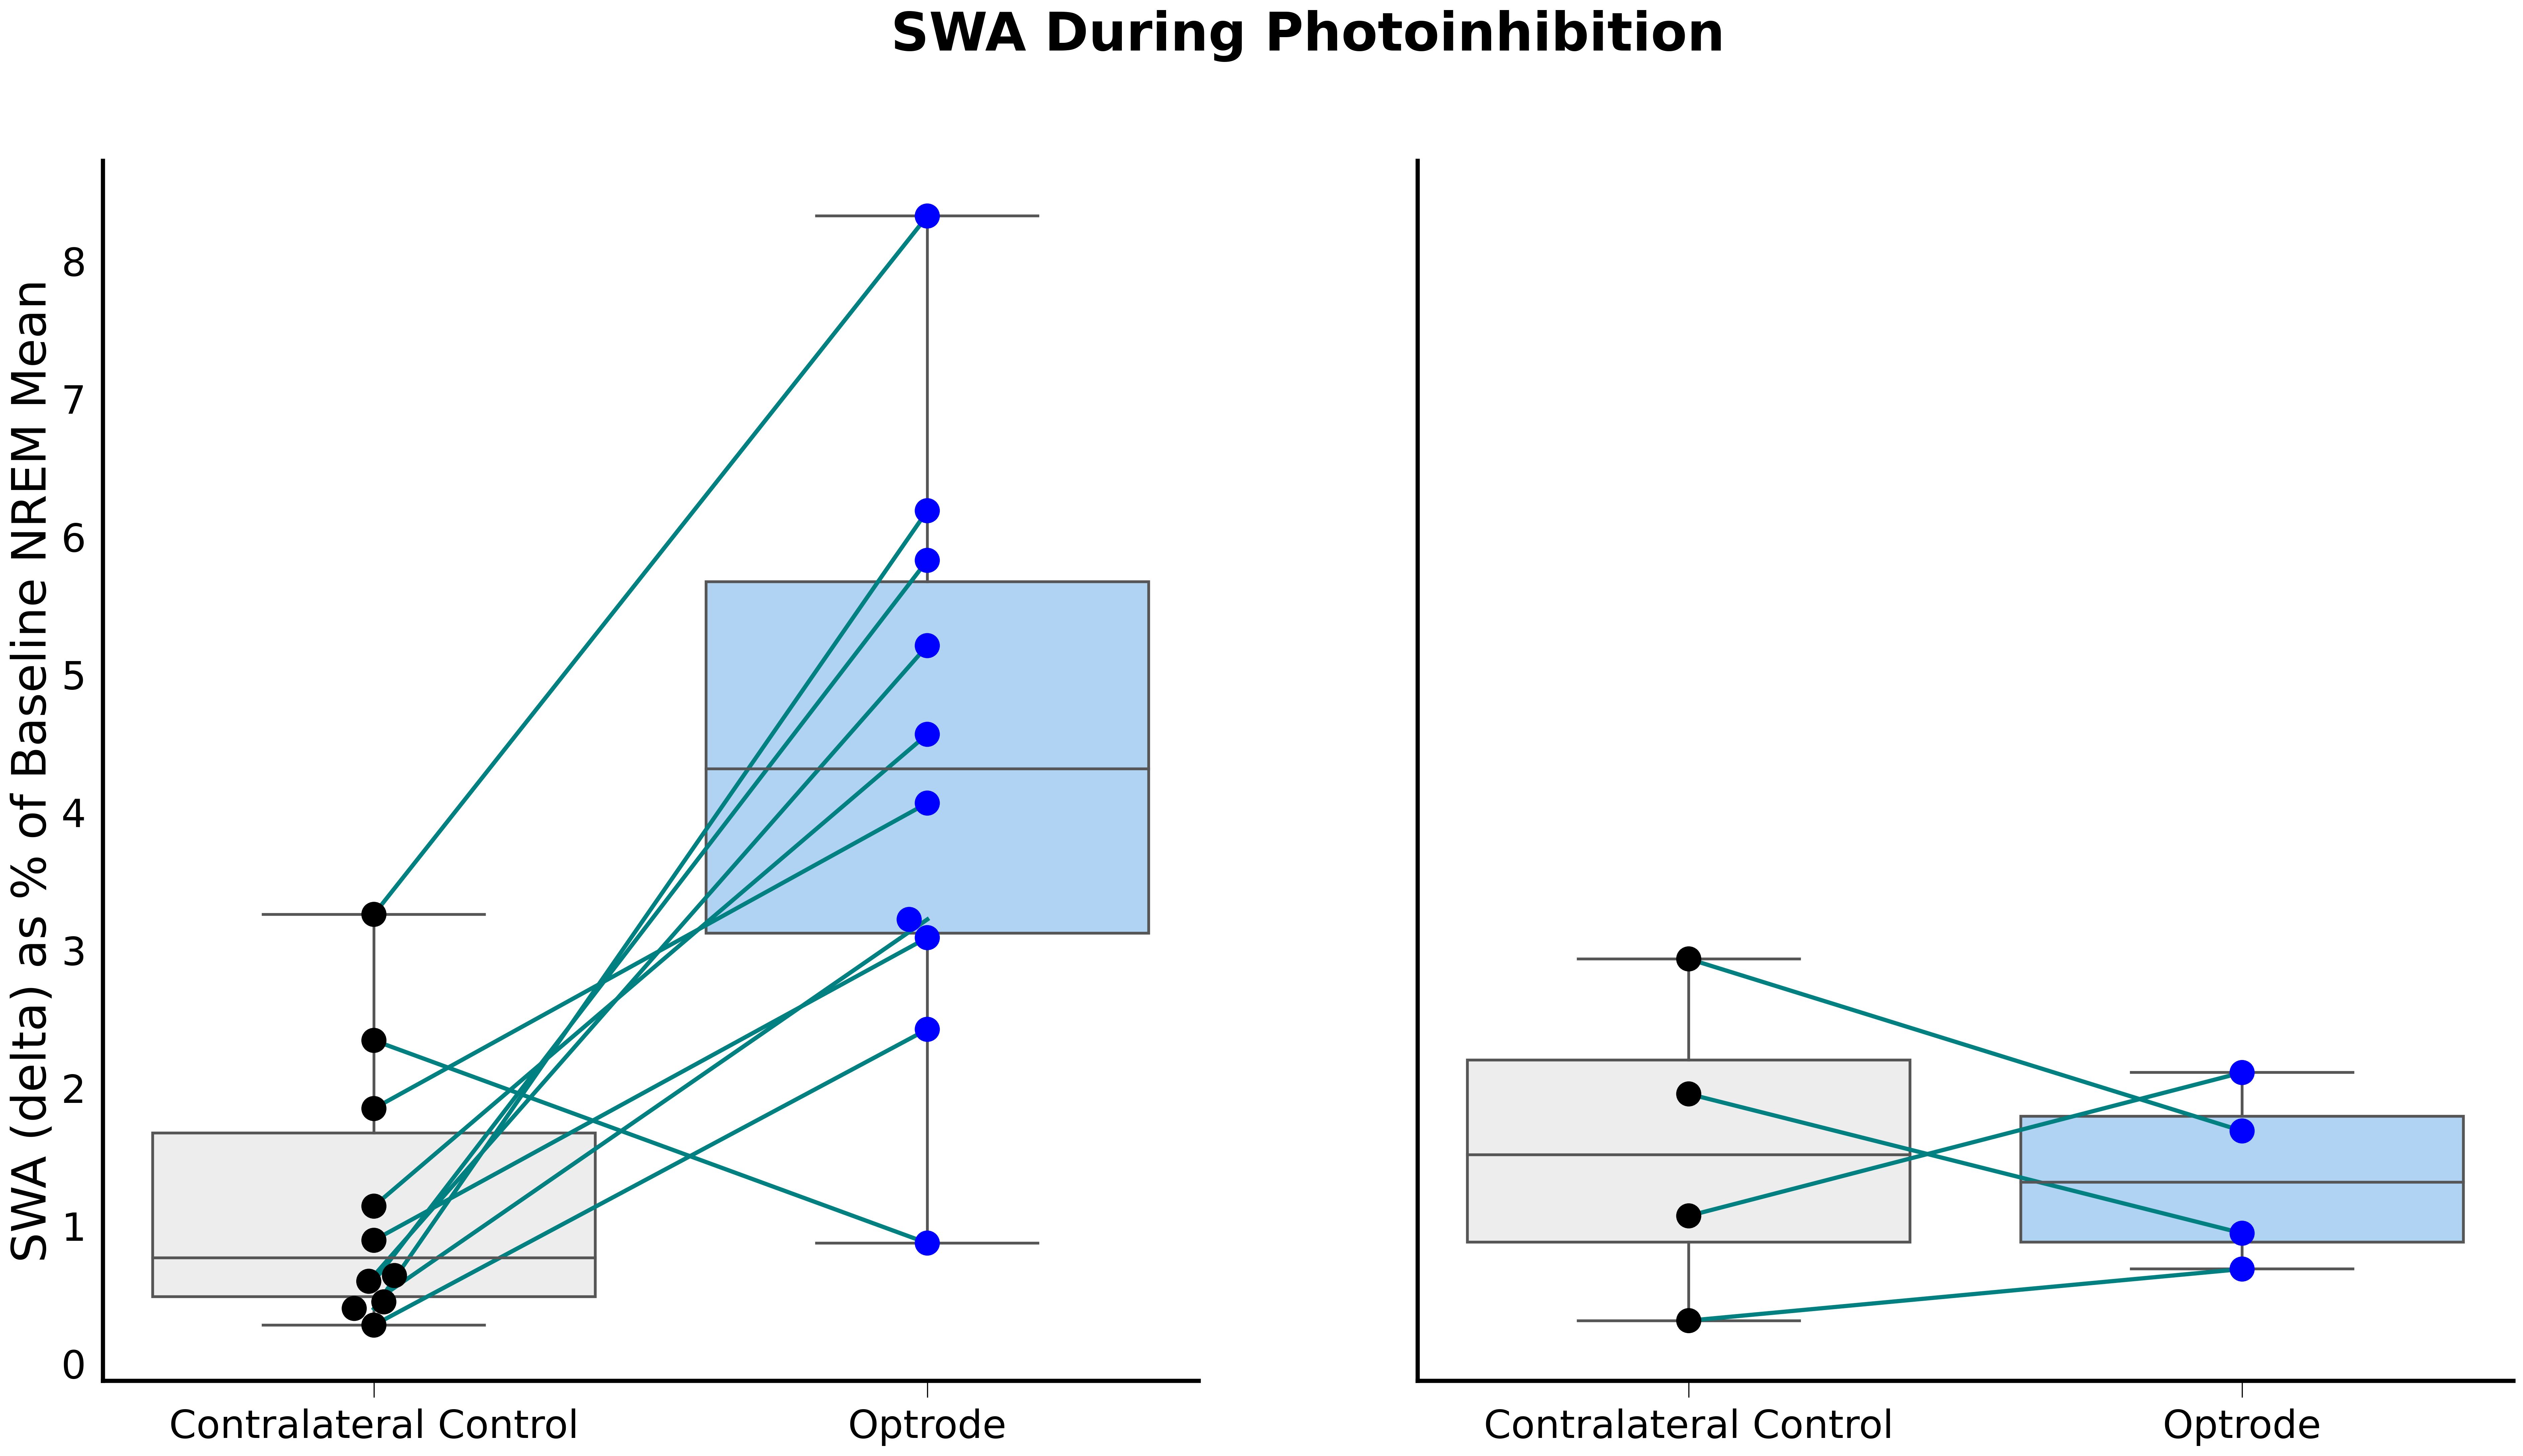

In [11]:
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharey=True)


# OFF-INDUCTION
sns.boxplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[0])
for patch in ax[0].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
sns.lineplot(data=sd_dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[0], linewidth=3)

ax[0].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[0].set_xlabel('')
#ax[0].set_title('OFF-Induction', fontsize=24)
ax[0].set_ylabel('SWA (delta) as % of Baseline NREM Mean')

# SINUSOIDAL
sns.boxplot(data=sd_dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[1])
for patch in ax[1].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=sd_dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])
sns.lineplot(data=sd_dex_means.exp_als('swisin'), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[1], linewidth=3)

ax[1].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[1].set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax[1].set_ylabel('')


# FIGURE-LEVEL
f.suptitle('SWA During Photoinhibition')
#ax[0].set_ylim(1.0, 3.0)
#ax[1].set_ylim(1.0, 3.0)

## Statistics

In [51]:
delta_during_swi_nnxr = sd_dex_means.loc[sd_dex_means.store=='NNXr'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_during_swi_nnxo = sd_dex_means.loc[sd_dex_means.store=='NNXo'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()

In [52]:
delta_during_swisin_nnxr = sd_dex_means.loc[sd_dex_means.store=='NNXr'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_during_swisin_nnxo = sd_dex_means.loc[sd_dex_means.store=='NNXo'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()

In [53]:
pg.ttest(delta_during_swi_nnxr, delta_during_swi_nnxo, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.714437,9,two-sided,0.001098,"[-4.73, -1.66]",1.922793,37.809,0.999653


In [54]:
pg.ttest(delta_during_swisin_nnxr, delta_during_swisin_nnxo, paired=True)

/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.38439,3,two-sided,0.726318,"[-1.54, 1.96]",0.22806,0.455,0.062725


# SWA differences during Rebound

In [36]:
reb_df = pl.read_csv('reb_df.csv')

## delta

In [37]:
delta_exp = reb_df.filter(pl.col('Band')=='delta').st('NREM').filter(pl.col('exp_type')=='exp')
delta_exp_means = delta_exp.groupby(['subject', 'exp', 'store']).mean().sort('Bandpower')
delta_exp_means = delta_exp_means.with_columns(exp_alias=pl.when(pl.col('exp')=='swi2').then('swi').otherwise(pl.col('exp')))

In [38]:
dex_means = delta_exp_means.to_pandas()

new_sub = 42 # Need to do this so I can connect the individual data points within experiments
for subject in dex_means.expmt('swi2').subject.unique():
    dex_means.loc[(dex_means.subject == subject) & (dex_means['exp'] == 'swi2'), 'subject'] = f'ACR_{new_sub}'
    new_sub += 1

/tmp/ipykernel_2913963/4189858005.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
/tmp/ipykernel_2913963/4189858005.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])


(1.0, 3.0)

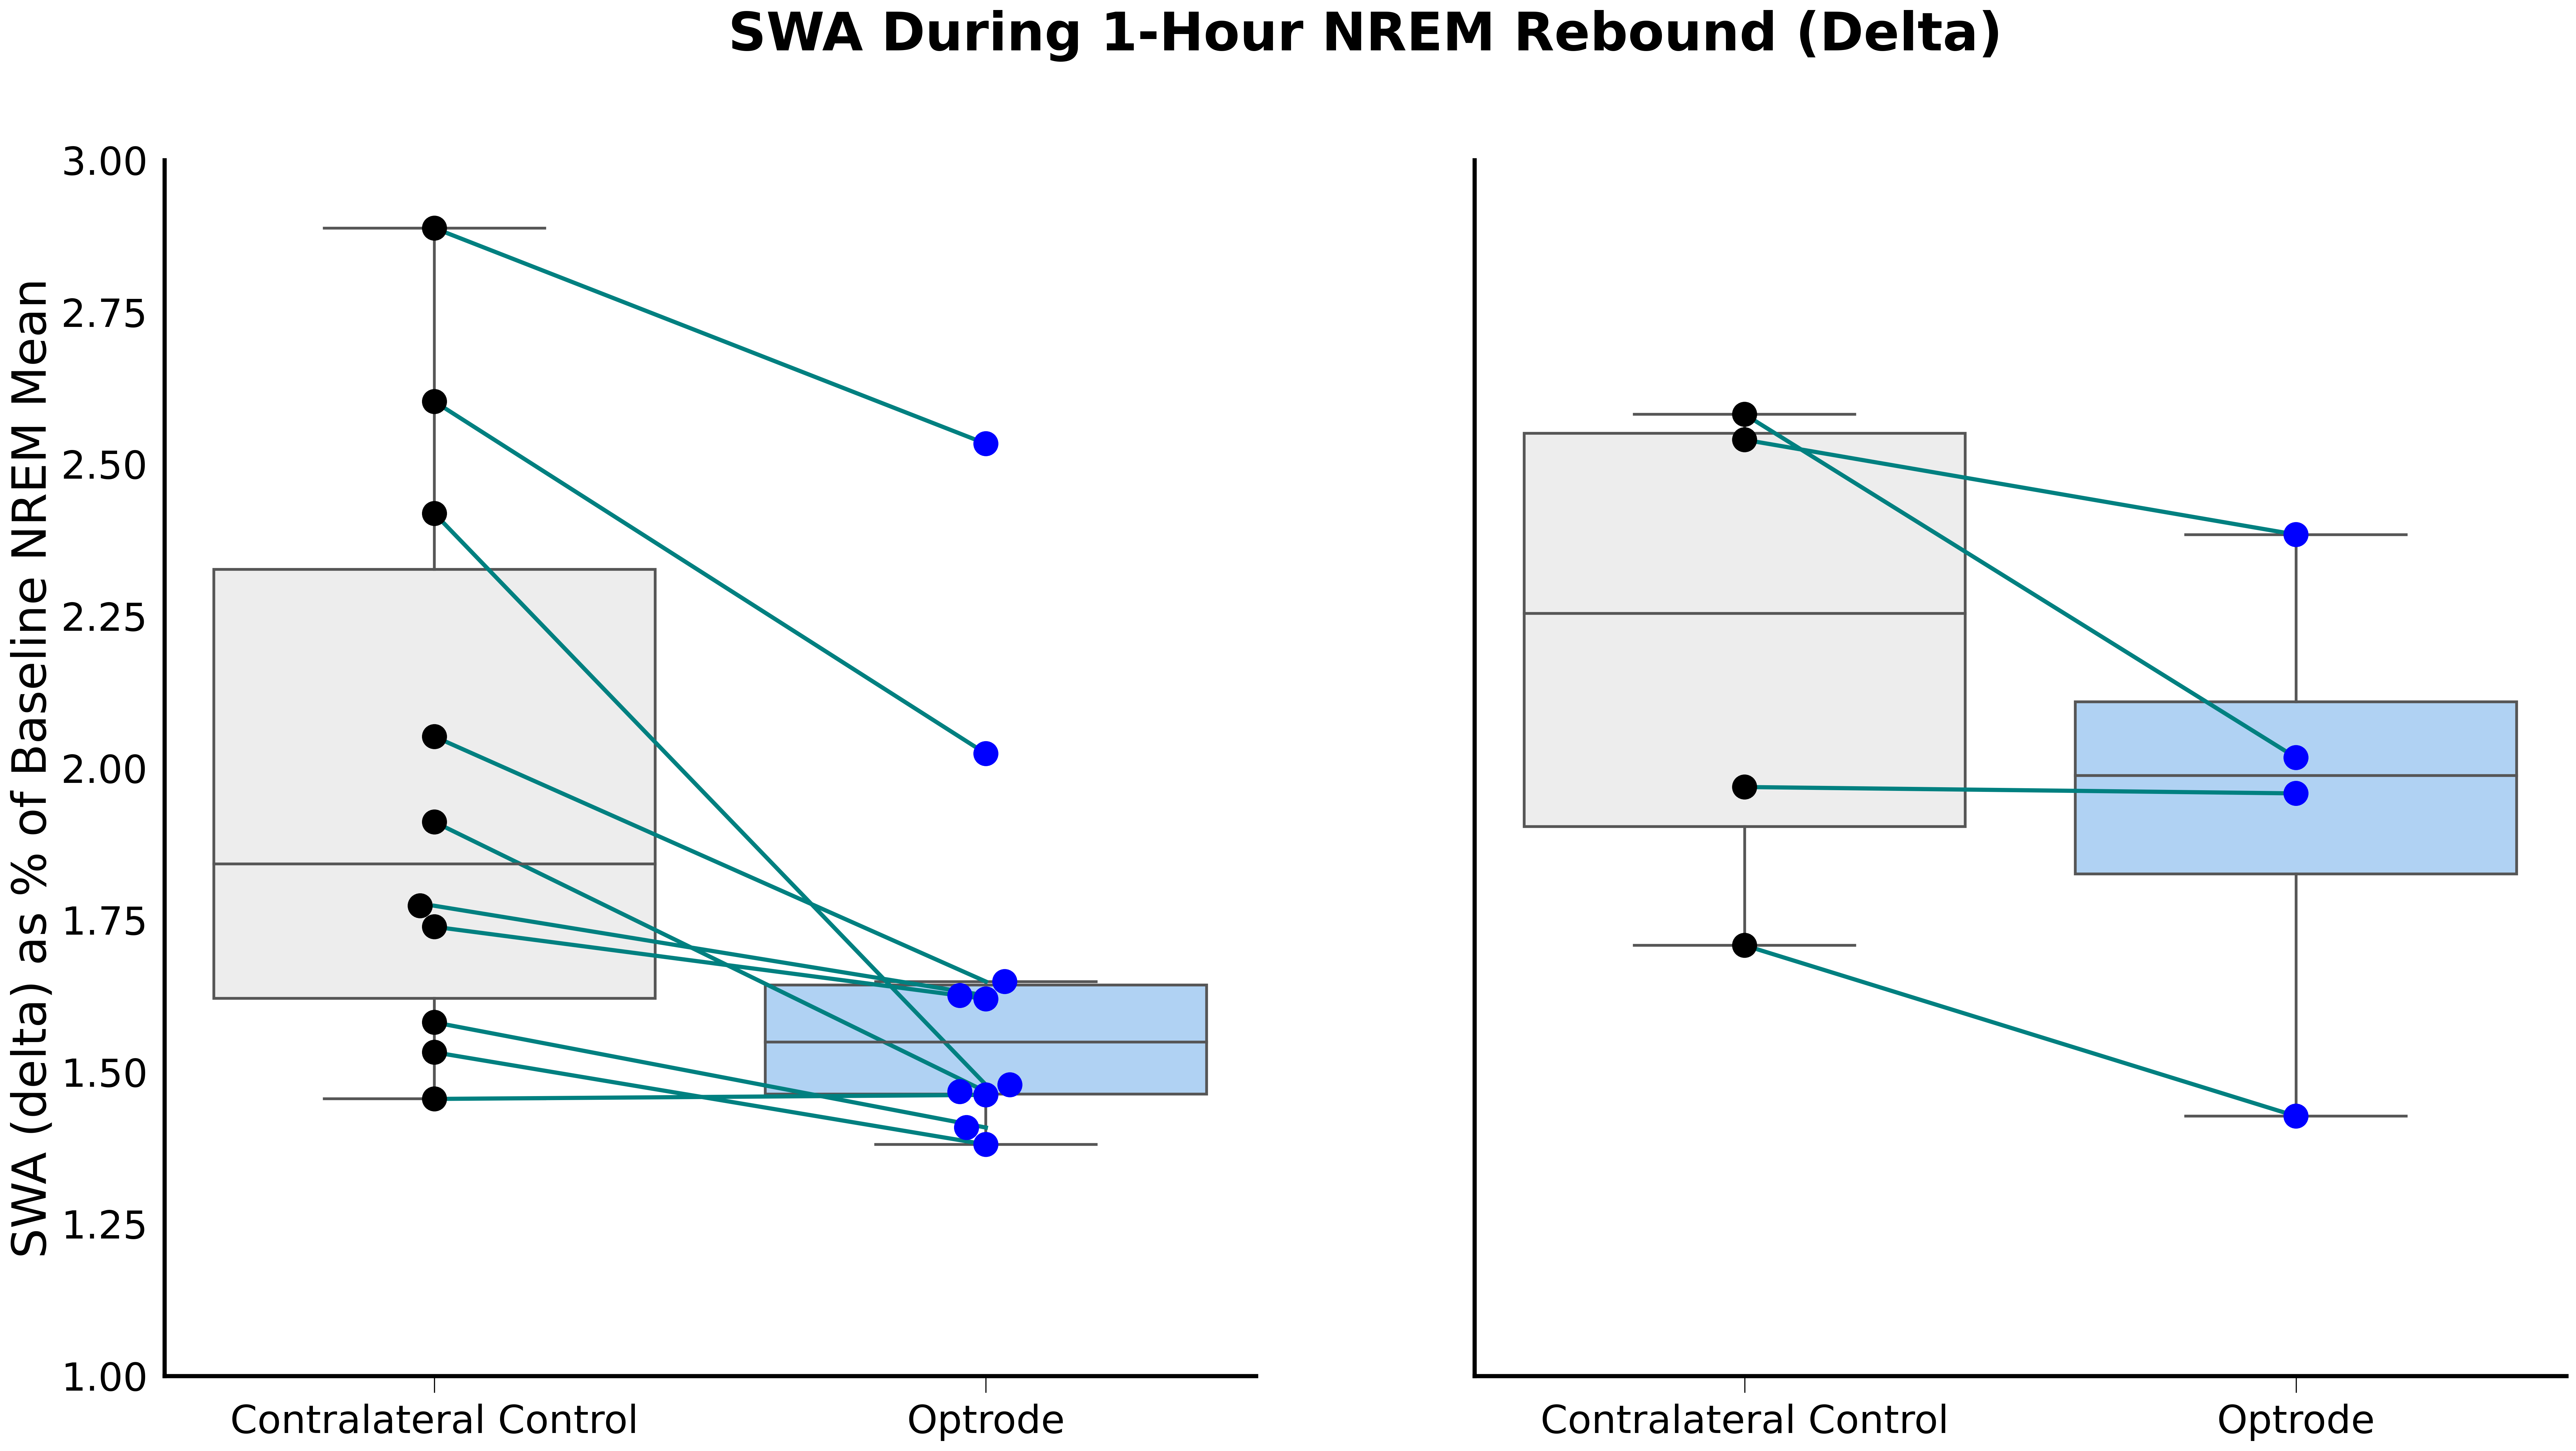

In [16]:
f, ax = plt.subplots(1, 2, figsize=(30, 15), sharey=True)


# OFF-INDUCTION
sns.boxplot(data=dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[0])
for patch in ax[0].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=dex_means.exp_als('swi'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[0])
sns.lineplot(data=dex_means.exp_als('swi'), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[0], linewidth=3)

ax[0].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[0].set_xlabel('')
#ax[0].set_title('OFF-Induction', fontsize=24)
ax[0].set_ylabel('SWA (delta) as % of Baseline NREM Mean')

# SINUSOIDAL
sns.boxplot(data=dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['lightgray', 'dodgerblue'], fliersize=0, ax=ax[1])
for patch in ax[1].patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))

sns.swarmplot(data=dex_means.exp_als('swisin'), x='store', y='Bandpower', order=['NNXr', 'NNXo'], palette=['black', 'blue'], marker='o', size=18, ax=ax[1])
sns.lineplot(data=dex_means.exp_als('swisin'), x='store', y='Bandpower', units='subject', estimator=None, color='teal', ax=ax[1], linewidth=3)

ax[1].set_xticklabels(['Contralateral Control', 'Optrode'])
ax[1].set_xlabel('')
#ax[1].set_title('Sinusoidal', fontsize=24)
ax[1].set_ylabel('')


# FIGURE-LEVEL
f.suptitle('SWA During 1-Hour NREM Rebound (Delta)')
ax[0].set_ylim(1.0, 3.0)
ax[1].set_ylim(1.0, 3.0)

## Stats

In [55]:
delta_reb_swi_nnxr = dex_means.loc[dex_means.store=='NNXr'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swi_nnxo = dex_means.loc[dex_means.store=='NNXo'].exp_als('swi').sort_values('subject')['Bandpower'].to_numpy()

In [56]:
delta_reb_swisin_nnxr = dex_means.loc[dex_means.store=='NNXr'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()
delta_reb_swisin_nnxo = dex_means.loc[dex_means.store=='NNXo'].exp_als('swisin').sort_values('subject')['Bandpower'].to_numpy()

In [57]:
pg.ttest(delta_reb_swi_nnxr, delta_reb_swi_nnxo, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.74622,9,two-sided,0.004581,"[0.13, 0.53]",0.772342,11.648,0.586424


In [60]:
pg.ttest(delta_reb_swisin_nnxr, delta_reb_swisin_nnxo, paired=True)

/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/home/kdriessen/miniconda3/envs/acrnew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.150216,3,two-sided,0.120683,"[-0.12, 0.63]",0.612885,1.309,0.141963
